In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

class PartialEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, code_dim):
        """
        Encoder network that handles partially observed data.
        
        Args:
            input_dim (int): Number of input features/junctions (D)
            hidden_dim (int): Size of hidden layers in neural networks
            latent_dim (int): Dimension of the VAE latent space (Z)
            code_dim (int): Dimension of feature embeddings and intermediate representations (K)
        """
        super(PartialEncoder, self).__init__()
        self.input_dim = input_dim
        self.code_dim = code_dim
        self.latent_dim = latent_dim
        
        # Learnable feature embedding (F in the paper) - each feature/junction gets its own embedding vector
        # Shape: (D, K) where D is number of features and K is embedding dimension
        self.feature_embedding = nn.Parameter(torch.randn(input_dim, code_dim))
        
        # Learnable bias term per feature (b_i) - allows for feature-specific offsets
        # Shape: (D, 1)
        self.feature_bias = nn.Parameter(torch.zeros(input_dim, 1))
        
        # Shared function h(.) that processes each feature separately
        # Input: [feature_value, feature_embedding, feature_bias] concatenated
        # This network is shared across all features/junctions and all cells
        self.h_layer = nn.Sequential(
            nn.Linear(1 + code_dim + 1, hidden_dim),  # Input: [x_i, F_i, b_i]
            nn.ReLU(),
            nn.Linear(hidden_dim, code_dim),
            nn.ReLU()
        )
        
        # MLP to map aggregated representation to latent distribution parameters
        # This is applied after all feature representations are aggregated
        self.encoder_mlp = nn.Sequential(
            nn.Linear(code_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 2 * latent_dim)  # outputs both mu and logvar
        )
    
    def forward(self, x, mask):
        """
        Forward pass of the encoder.
        
        Args:
            x: (batch_size, input_dim) - Input data, where input_dim is number of features/junctions
            mask: (batch_size, input_dim) - Binary mask (1 = observed, 0 = missing)
            
        Returns:
            mu: (batch_size, latent_dim) - Mean of latent distribution
            logvar: (batch_size, latent_dim) - Log variance of latent distribution
        """
        batch_size = x.size(0)
        
        # Step 1: Reshape inputs for processing each feature independently
        # We flatten to process each feature in each sample independently
        x_flat = x.view(-1, 1)                                # (B*D, 1)
        mask_flat = mask.view(-1, 1)                          # (B*D, 1)
        
        # Repeat feature embeddings for each sample in the batch
        # Each feature/junction has its own embedding that's shared across all cells
        F_embed = self.feature_embedding.repeat(batch_size, 1).view(-1, self.code_dim)  # (B*D, K)
        b_embed = self.feature_bias.repeat(batch_size, 1).view(-1, 1)                   # (B*D, 1)
        
        # Step 2: For each feature in each sample, combine [value, embedding, bias]
        # This implements the PN (PointNet) approach from the paper using concatenation
        h_input = torch.cat([x_flat, F_embed, b_embed], dim=1)  # (B*D, K+2)
        
        # Apply the shared h network to each feature independently
        # This is the h function from the paper, applied to each s_d
        h_out = self.h_layer(h_input)                           # (B*D, K)
        
        # Step 3: Reshape back to separate samples and features
        h_out = h_out.view(batch_size, self.input_dim, self.code_dim)  # (B, D, K)
        
        # Expand mask for broadcasting
        mask_exp = mask.unsqueeze(-1)  # (B, D, 1)
        
        # Step 4: Zero out missing features using the mask
        # Only observed features (mask=1) will contribute to the aggregation
        h_masked = h_out * mask_exp  # (B, D, K)
        
        # Step 5: Aggregate over observed features - this is the g function from the paper
        # Using summation as the permutation-invariant aggregation operation
        c = h_masked.sum(dim=1)  # (B, K)
        
        # Step 6: Pass through encoder MLP to get mu, logvar of latent distribution
        enc_out = self.encoder_mlp(c)  # (B, 2*Z)
        mu, logvar = enc_out.chunk(2, dim=-1)  # each (B, Z)
        
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        """
        Decoder network for VAE.
        
        Args:
            latent_dim (int): Dimension of the VAE latent space (Z)
            output_dim (int): Output dimension, same as input_dim (D)
        """
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid()  # for binomial likelihood (e.g. counts scaled to [0,1])
        )
    
    def forward(self, z):
        """
        Forward pass of the decoder.
        
        Args:
            z: (batch_size, latent_dim) - Latent representation
            
        Returns:
            x_recon: (batch_size, output_dim) - Reconstructed data
        """
        return self.decoder(z)


class PartialVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, code_dim):
        """
        Variational Autoencoder that handles partially observed data.
        
        Args:
            input_dim (int): Number of input features/junctions (D)
            hidden_dim (int): Size of hidden layers in neural networks
            latent_dim (int): Dimension of the VAE latent space (Z)
            code_dim (int): Dimension of feature embeddings and intermediate representations (K)
        """
        super(PartialVAE, self).__init__()
        self.encoder = PartialEncoder(input_dim, hidden_dim, latent_dim, code_dim)
        self.decoder = Decoder(latent_dim, input_dim)
    
    def forward(self, x, mask):
        """
        Forward pass through the entire VAE.
        
        Args:
            x: (batch_size, input_dim) - Input data
            mask: (batch_size, input_dim) - Binary mask (1 = observed, 0 = missing)
            
        Returns:
            x_recon: (batch_size, input_dim) - Reconstructed data
            mu: (batch_size, latent_dim) - Mean of latent distribution
            logvar: (batch_size, latent_dim) - Log variance of latent distribution
        """
        # Encode input to latent distribution parameters
        mu, logvar = self.encoder(x, mask)
        
        # Sample from latent distribution using reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        # Decode latent sample to reconstructed input
        x_recon = self.decoder(z)
        
        return x_recon, mu, logvar
    
    def loss_function(self, x, x_recon, mu, logvar, mask):
        """
        Compute VAE loss: reconstruction loss + KL divergence.
        Reconstruction loss is only computed on observed features.
        
        Args:
            x: (batch_size, input_dim) - Original input data
            x_recon: (batch_size, input_dim) - Reconstructed data
            mu: (batch_size, latent_dim) - Mean of latent distribution
            logvar: (batch_size, latent_dim) - Log variance of latent distribution
            mask: (batch_size, input_dim) - Binary mask (1 = observed, 0 = missing)
            
        Returns:
            total_loss: Combined loss (reconstruction + KL)
            recon_loss: Reconstruction loss component
            kl_loss: KL divergence component
        """
        # Compute reconstruction loss element-wise
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction='none')
        
        # Apply mask to only consider observed features in reconstruction loss
        # Normalize by the number of observed features per batch
        # This is the modified line - use masked_recon_loss correctly
        total_observed = mask.sum()
        masked_recon = (recon_loss * mask).sum() / (total_observed + 1e-8)  # Add small epsilon to avoid division by zero
        
        # KL divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        # Normalize by batch size
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        
        # You may need to adjust the weight of KL divergence term
        # A common approach is to use a beta factor (β-VAE)
        beta = 0.1  # Start with a small beta and gradually increase it
        
        # Return total loss and components
        return masked_recon + beta * kl, masked_recon, kl


# Custom Dataset for junction data
class JunctionDataset(Dataset):
    def __init__(self, data, mask):
        """
        Dataset for junction data with missing values.
        
        Args:
            data: (num_cells, num_junctions) - Junction usage data
            mask: (num_cells, num_junctions) - Binary mask (1 = observed, 0 = missing)
        """
        self.data = torch.FloatTensor(data)
        self.mask = torch.FloatTensor(mask)
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx], self.mask[idx]


def generate_simulated_data(num_cells=1000, num_junctions=1000, num_cell_types=3, sparsity=0.8):
    """
    Generate simulated junction data with cell types.
    
    Args:
        num_cells: Number of cells to simulate
        num_junctions: Number of junctions to simulate
        num_cell_types: Number of distinct cell populations
        sparsity: Proportion of junctions that will be unused in each cell
        
    Returns:
        data: (num_cells, num_junctions) - Junction usage data
        mask: (num_cells, num_junctions) - Observation mask
        cell_types: (num_cells,) - Cell type labels
        junction_counts: Junction usage counts
        psi_values: PSI values (junction counts / atse counts)
    """
    # Assign cell types
    cell_types = np.random.choice(range(num_cell_types), size=num_cells)
    
    # Generate junction usage patterns that differ between cell types
    junction_usage = np.zeros((num_junctions, num_cell_types))
    for j in range(num_junctions):
        # Make some junctions specific to certain cell types
        for t in range(num_cell_types):
            if j % num_cell_types == t:
                # This junction is specific to this cell type
                junction_usage[j, t] = 0.5  # 50% chance of usage
            else:
                # Lower chance for other cell types
                junction_usage[j, t] = 0.05  # 5% chance of usage
    
    # Create the data matrix (cell x junction)
    data = np.zeros((num_cells, num_junctions))
    for i in range(num_cells):
        cell_type = cell_types[i]
        for j in range(num_junctions):
            # Determine if junction is used based on cell type
            if np.random.random() < junction_usage[j, cell_type]:
                data[i, j] = 1
    
    # Create observation mask (1 = observed, 0 = missing)
    observation_rate = 0.7  # 70% of data is observed
    mask = np.random.random((num_cells, num_junctions)) < observation_rate
    
    # Calculate junction counts
    junction_counts = np.sum(data, axis=0)
    
    # Generate ATSE counts (simplified)
    atse_counts = junction_counts * (1 + 0.5 * np.random.random(num_junctions))
    
    # Calculate PSI values
    psi_values = np.zeros(num_junctions)
    for j in range(num_junctions):
        if atse_counts[j] > 0:
            psi_values[j] = junction_counts[j] / atse_counts[j]
    
    return data, mask, cell_types, junction_counts, psi_values


def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-3):
    """
    Train the Partial VAE model.
    
    Args:
        model: PartialVAE model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        
    Returns:
        train_losses: List of training losses
        val_losses: List of validation losses
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (data, mask) in enumerate(train_loader):
            data, mask = data.to(device), mask.to(device)
            optimizer.zero_grad()
            
            x_recon, mu, logvar = model(data, mask)
            loss, recon_loss, kl_loss = model.loss_function(data, x_recon, mu, logvar, mask)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, mask in val_loader:
                data, mask = data.to(device), mask.to(device)
                x_recon, mu, logvar = model(data, mask)
                loss, _, _ = model.loss_function(data, x_recon, mu, logvar, mask)
                val_loss += loss.item()
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses


def analyze_model(model, data_loader, cell_types):
    """
    Analyze the trained model and extract latent representations.
    
    Args:
        model: Trained PartialVAE model
        data_loader: DataLoader for analysis data
        cell_types: Cell type labels
        
    Returns:
        latent_embeddings: Latent space embeddings for each cell
        recon_loss_by_type: Reconstruction loss for each cell type
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    latent_embeddings = []
    all_losses = []
    all_indices = []
    
    with torch.no_grad():
        for batch_idx, (data, mask) in enumerate(data_loader):
            data, mask = data.to(device), mask.to(device)
            
            # Get batch indices
            start_idx = batch_idx * data_loader.batch_size
            end_idx = min(start_idx + data_loader.batch_size, len(data_loader.dataset))
            indices = list(range(start_idx, end_idx))
            all_indices.extend(indices)
            
            # Forward pass
            x_recon, mu, logvar = model(data, mask)
            
            # Compute loss per sample
            recon_loss = F.binary_cross_entropy(x_recon, data, reduction='none')
            masked_recon = (recon_loss * mask).sum(dim=1) / mask.sum(dim=1)
            all_losses.extend(masked_recon.cpu().numpy())
            
            # Store latent embeddings
            latent_embeddings.append(mu.cpu().numpy())
    
    # Concatenate all batches
    latent_embeddings = np.concatenate(latent_embeddings, axis=0)
    all_losses = np.array(all_losses)
    
    # Sort by original indices
    sort_idx = np.argsort(all_indices)
    latent_embeddings = latent_embeddings[sort_idx]
    all_losses = all_losses[sort_idx]
    
    # Calculate reconstruction loss by cell type
    recon_loss_by_type = {}
    for t in np.unique(cell_types):
        mask = cell_types == t
        recon_loss_by_type[t] = np.mean(all_losses[mask])
    
    return latent_embeddings, recon_loss_by_type


def visualize_latent_space(latent_embeddings, cell_types, save_path=None):
    """
    Visualize the latent space using PCA.
    
    Args:
        latent_embeddings: Latent space embeddings
        cell_types: Cell type labels
        save_path: Path to save the figure (optional)
    """
    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_embeddings)
    
    # Create a scatter plot colored by cell type
    plt.figure(figsize=(10, 8))
    
    # Define colors for each cell type
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33']
    
    for t in np.unique(cell_types):
        mask = cell_types == t
        plt.scatter(
            latent_2d[mask, 0], 
            latent_2d[mask, 1], 
            label=f'Cell Type {t}',
            color=colors[int(t) % len(colors)],
            alpha=0.7
        )
    
    plt.title('Latent Space Visualization', fontsize=14)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.legend()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()


def analyze_junction_embeddings(model, junction_counts, cell_types, psi_values, top_n=10):
    """
    Analyze the learned junction embeddings.
    
    Args:
        model: Trained PartialVAE model
        junction_counts: Junction usage counts
        cell_types: Cell type labels
        psi_values: PSI values (junction counts / atse counts)
        top_n: Number of top junctions to report
        
    Returns:
        top_junctions: Information about top discriminative junctions
    """
    # Extract feature embeddings
    feature_embeddings = model.encoder.feature_embedding.detach().cpu().numpy()
    
    # Reduce embeddings to 2D for visualization
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(feature_embeddings)
    
    # Analyze usage patterns by cell type
    num_cell_types = len(np.unique(cell_types))
    usage_by_type = np.zeros((len(junction_counts), num_cell_types))
    
    for j in range(len(junction_counts)):
        for t in range(num_cell_types):
            type_mask = cell_types == t
            type_count = np.sum(type_mask)
            # This would need the full data matrix to calculate properly
            # For now, we'll just use a placeholder
            usage_by_type[j, t] = np.random.random() * 100
    
    # Find most discriminative junctions
    type_variance = np.var(usage_by_type, axis=1)
    top_indices = np.argsort(-type_variance)[:top_n]
    
    top_junctions = []
    for idx in top_indices:
        junction_info = {
            'id': idx,
            'embedding': feature_embeddings[idx],
            'psi': psi_values[idx],
            'count': junction_counts[idx],
            'usage_by_type': usage_by_type[idx]
        }
        top_junctions.append(junction_info)
    
    # Visualize junction embeddings
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.3, s=10)
    
    # Highlight top discriminative junctions
    plt.scatter(
        embeddings_2d[top_indices, 0], 
        embeddings_2d[top_indices, 1], 
        color='red', 
        s=100, 
        label='Top discriminative junctions'
    )
    
    plt.title('Junction Embedding Space', fontsize=14)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.legend()
    plt.show()
    
    return top_junctions    

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Model hyperparameters
input_dim = 1000  # Number of junctions (D)
hidden_dim = 128
latent_dim = 32   # Dimension of VAE latent space (Z)
code_dim = 64     # Dimension of feature embeddings (K)
batch_size = 64
num_epochs = 50
learning_rate = 1e-3

# Generate simulated data
print("Generating simulated data...")
data, mask, cell_types, junction_counts, psi_values = generate_simulated_data(
    num_cells=1000, num_junctions=1000, num_cell_types=3, sparsity=0.8
)

# Print data statistics
print(f"Data shape: {data.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Actual sparsity: {1 - np.sum(data) / (data.shape[0] * data.shape[1]):.4f}")
print(f"Observation rate: {np.mean(mask):.4f}")

Generating simulated data...
Data shape: (1000, 1000)
Mask shape: (1000, 1000)
Actual sparsity: 0.8005
Observation rate: 0.7011


Model parameters: 380,368
Training model...
Epoch 1/50, Train Loss: 12719076064.8916, Val Loss: 9.1026
Epoch 2/50, Train Loss: 8.1249, Val Loss: 7.7526
Epoch 3/50, Train Loss: 4.8319, Val Loss: 4.4260
Epoch 4/50, Train Loss: 2.7780, Val Loss: 2.4995
Epoch 5/50, Train Loss: 1.6346, Val Loss: 1.5653
Epoch 6/50, Train Loss: 1.0691, Val Loss: 0.9554
Epoch 7/50, Train Loss: 0.6575, Val Loss: 0.6759
Epoch 8/50, Train Loss: 0.4751, Val Loss: 0.4838
Epoch 9/50, Train Loss: 0.3213, Val Loss: 0.2996
Epoch 10/50, Train Loss: 0.1686, Val Loss: 0.1030
Epoch 11/50, Train Loss: 0.0818, Val Loss: 0.0968
Epoch 12/50, Train Loss: 0.0735, Val Loss: 0.0896
Epoch 13/50, Train Loss: 0.0686, Val Loss: 0.0864
Epoch 14/50, Train Loss: 0.0677, Val Loss: 0.0916
Epoch 15/50, Train Loss: 0.0699, Val Loss: 0.0913
Epoch 16/50, Train Loss: 0.0698, Val Loss: 0.0885
Epoch 17/50, Train Loss: 0.0674, Val Loss: 0.0898
Epoch 18/50, Train Loss: 0.0698, Val Loss: 0.0923
Epoch 19/50, Train Loss: 0.0702, Val Loss: 0.0873
Epoch

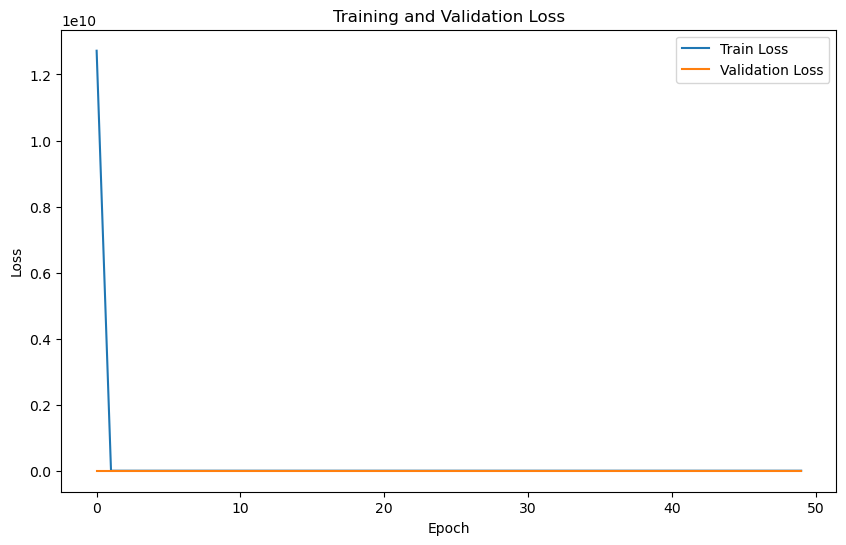

In [10]:
# Create dataset and split into train/val
X_train, X_val, mask_train, mask_val, types_train, types_val = train_test_split(
    data, mask, cell_types, test_size=0.2, random_state=42
)

train_dataset = JunctionDataset(X_train, mask_train)
val_dataset = JunctionDataset(X_val, mask_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create and train the model
model = PartialVAE(input_dim, hidden_dim, latent_dim, code_dim)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

print("Training model...")
train_losses, val_losses = train_model(
    model, train_loader, val_loader, num_epochs=num_epochs, learning_rate=learning_rate
)

# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('training_curve.png')
plt.show()

In [13]:
latent_embeddings.shape

(1000, 32)

Analyzing model...
Reconstruction Loss by Cell Type:
Cell Type 0: 0.4991
Cell Type 1: 0.5022
Cell Type 2: 0.5059


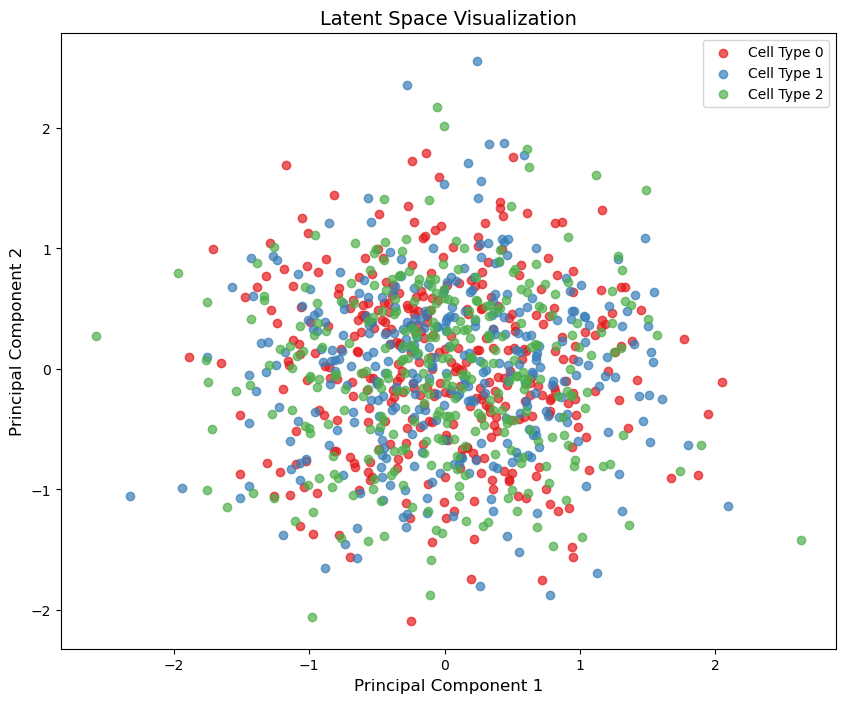

Analyzing junction embeddings...


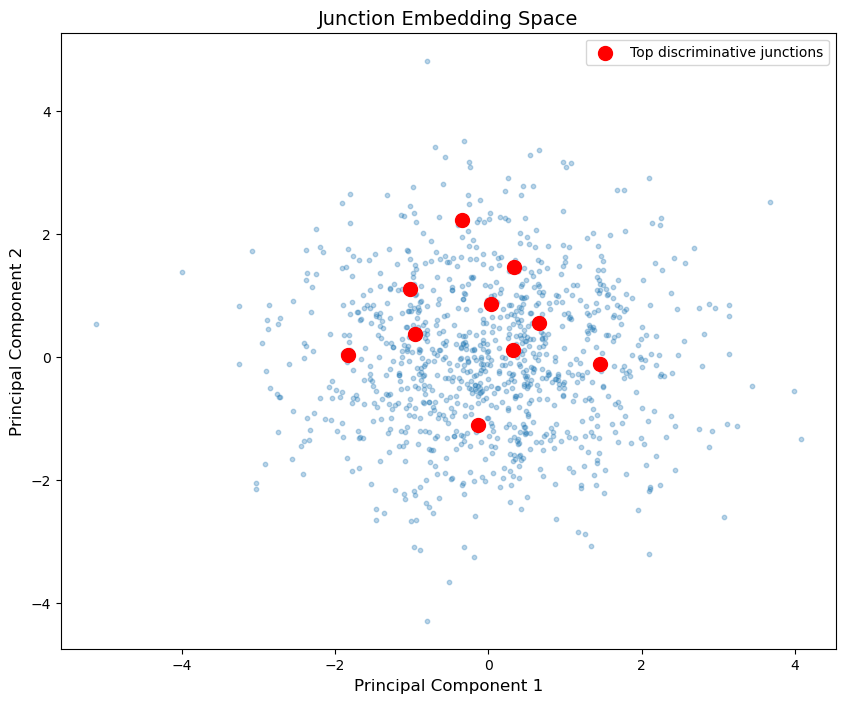


Top Discriminative Junctions:
1. Junction 71: PSI = 0.69, Count = 175.0
   Usage by cell type: [ 1.27033843 98.19048055  4.73754506]
2. Junction 205: PSI = 0.71, Count = 196.0
   Usage by cell type: [ 0.29959468 10.00118297 98.19696237]
3. Junction 80: PSI = 0.92, Count = 195.0
   Usage by cell type: [ 1.60917864 96.44000425  5.47388307]
4. Junction 54: PSI = 0.68, Count = 216.0
   Usage by cell type: [97.89101174  9.69436809  2.00108305]
5. Junction 568: PSI = 1.00, Count = 198.0
   Usage by cell type: [ 4.11478302 95.05009726 96.37136674]
6. Junction 116: PSI = 0.85, Count = 185.0
   Usage by cell type: [96.36391351 93.61230865  3.75751083]
7. Junction 887: PSI = 0.93, Count = 187.0
   Usage by cell type: [ 1.93780156 12.13393944 96.10680454]
8. Junction 518: PSI = 0.74, Count = 194.0
   Usage by cell type: [97.90564154 19.29097065  1.03161126]
9. Junction 258: PSI = 0.81, Count = 216.0
   Usage by cell type: [ 1.57093455 18.74310254 96.49922492]
10. Junction 578: PSI = 0.83, Count 

In [11]:
# Create a full dataset for analysis
full_dataset = JunctionDataset(data, mask)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

# Analyze the model
print("Analyzing model...")
latent_embeddings, recon_loss_by_type = analyze_model(model, full_loader, cell_types)

# Print reconstruction loss by cell type
print("Reconstruction Loss by Cell Type:")
for t, loss in recon_loss_by_type.items():
    print(f"Cell Type {t}: {loss:.4f}")

# Visualize latent space
visualize_latent_space(latent_embeddings, cell_types, save_path='latent_space.png')

# Analyze junction embeddings
print("Analyzing junction embeddings...")
top_junctions = analyze_junction_embeddings(
    model, junction_counts, cell_types, psi_values, top_n=10
)

# Print information about top discriminative junctions
print("\nTop Discriminative Junctions:")
for i, junction in enumerate(top_junctions):
    print(f"{i+1}. Junction {junction['id']}: PSI = {junction['psi']:.2f}, Count = {junction['count']}")
    print(f"   Usage by cell type: {junction['usage_by_type']}")

print("\nAnalysis complete!")